In [1]:
# import gdown
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import mediapipe as mp
from ldmodel import EfficientNetLandMark
from scipy.spatial import Delaunay
import pandas as pd
# from torchsummary import summary

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.4 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
import torch
print(torch.__version__)

2.2.0+cu121


In [3]:
class Filter():
    def __init__(self, landmark_model, transform):
        self.modelFile = "res10_300x300_ssd_iter_140000.caffemodel"
        self.configFile = "deploy.prototxt"
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.landmark_detect = landmark_model
        self.transform = transform
        self.face_detect = cv2.dnn.readNetFromCaffe(self.configFile, self.modelFile)
        self.landmark_detect.eval()
    

    def load_filter_landmarks(self, filter_annotate):
        df = pd.read_csv(filter_annotate, header=None)
        x = df[1].values
        y = df[2].values
        return np.array([(x1, y1) for x1, y1 in zip(x, y)])


    def apply_affine_transform(self, filter_frag, transparent_frag, src_triangle, des_triangle, size):
        warp_mat = cv2.getAffineTransform(np.float32(src_triangle), np.float32(des_triangle))
        filter_frag = cv2.warpAffine(filter_frag, warp_mat, size, None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        transparent_frag = cv2.warpAffine(transparent_frag, warp_mat, size, None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        return filter_frag, transparent_frag
    

    def apply_filter(self, filter_img, face_img, filter_tri, face_tri, transparent_mask):
        filter_rec = cv2.boundingRect(filter_tri)
        face_rec = cv2.boundingRect(face_tri)
        
        filter_offset = [(filter_tri[i][0] - filter_rec[0], filter_tri[i][1] - filter_rec[1]) for i in range(3)]
        face_offset = [(face_tri[i][0] - face_rec[0], face_tri[i][1] - face_rec[1]) for i in range(3)]
        face_offset_int = [(int(face_tri[i][0] - face_rec[0]), int(face_tri[i][1] - face_rec[1])) for i in range(3)]
        
        mask = np.zeros((face_rec[3], face_rec[2], 3), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(face_offset_int), (1, 1, 1), 16, 0)

        filter_frag = filter_img[filter_rec[1]:(filter_rec[1] + filter_rec[3]), filter_rec[0]:(filter_rec[0] + filter_rec[2])]
        transparent_frag = transparent_mask[filter_rec[1]:(filter_rec[1] + filter_rec[3]), filter_rec[0]:(filter_rec[0] + filter_rec[2])] / 255
        size = (face_rec[2], face_rec[3])
        
        face_frag, transparent_frag = self.apply_affine_transform(filter_frag, transparent_frag, filter_offset, face_offset, size)

        face_frag *= mask
        face_frag *= transparent_frag.astype(np.uint32)

        try:
            face_img[face_rec[1]:(face_rec[1] + face_rec[3]), face_rec[0]:(face_rec[0] + face_rec[2])] *= ((1, 1, 1) - mask * transparent_frag).astype(np.uint32)
            face_img[face_rec[1]:(face_rec[1] + face_rec[3]), face_rec[0]:(face_rec[0] + face_rec[2])] += face_frag
        except:
            pass


    def landmarks_detect(self, image):
        height, width, channels = image.shape
        
        image = self.transform(image=image)['image']
        image = image.to(self.device)
        in_height, in_width, in_channel = image.shape
        image = image.unsqueeze(0)
        landmarks = self.landmark_detect(image)
        landmarks = landmarks.reshape(68, 2)
        
        # convert to 0-224 axis
        landmarks = (landmarks + 0.5) * in_width
        # convert to original axis
        landmarks[:, 0] = landmarks[:, 0] / in_width * width
        landmarks[:, 1] = landmarks[:, 1] / in_width * height
        
        return landmarks
        
        
    def filter_image(self, image_path, radius=1, filter='anonymous'):
        filter_image_path = "annotate filter\\image\\" + filter + ".png"
        filter_annotate_path = "annotate filter\\csv\\" + filter + "_annotations.csv"

        filter_landmarks = self.load_filter_landmarks(filter_annotate=filter_annotate_path)
        delau_tri = Delaunay(filter_landmarks)
        filter_img = cv2.imread(filter_image_path, cv2.IMREAD_UNCHANGED)
        
        b, g, r, a = cv2.split(filter_img)
        a = np.stack((a,) * 3, axis=-1)
        filter_img = cv2.merge((b, g, r))


        # mediapipe
        self.face_detect = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=1)

        # Load the image (np.ndarray)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert BGR to RGB (np.ndarray)
        height, width, channels = image.shape

        # Detect faces in the image
        faces = self.face_detect.process(image)

        # Draw rectangles around the detected faces
        for face in faces.detections:
            bbox = face.location_data.relative_bounding_box
            left = int(round(bbox.xmin * width))
            top = int(round(bbox.ymin * height))
            right = int(round((bbox.xmin + bbox.width) * width))
            bottom = int(round((bbox.ymin + bbox.height) * height))
            
            landmarks = self.landmarks_detect(image[top:bottom, left:right])
            landmarks = landmarks.detach().cpu().numpy()
            landmarks = landmarks + [left, top]
            landmarks = np.append(landmarks, [[left + 50, top]], axis=0)
            landmarks = np.append(landmarks, [[right - 50, top]], axis=0)

            
            cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
            for tri in delau_tri.simplices:
                face_tri = landmarks[tri].astype(np.int32)
                filter_tri = filter_landmarks[tri].astype(np.int32)
                self.apply_filter(filter_img=filter_img, face_img=image, filter_tri=filter_tri, face_tri=face_tri, transparent_mask=a)

        # Display the image with detected faces
        plt.imshow(image)
        plt.show()


    def filter_video(self, radius=1, filter='anonymous'):
        filter_image_path = "annotate filter\\image\\" + filter + ".png"
        filter_annotate_path = "annotate filter\\csv\\" + filter + "_annotations.csv"

        filter_landmarks = self.load_filter_landmarks(filter_annotate=filter_annotate_path)
        delau_tri = Delaunay(filter_landmarks)
        filter_img = cv2.imread(filter_image_path, cv2.IMREAD_UNCHANGED)
        
        b, g, r, a = cv2.split(filter_img)
        a = np.stack((a,) * 3, axis=-1)
        filter_img = cv2.merge((b, g, r))

        # ResNet
        self.face_detect = cv2.dnn.readNetFromCaffe(self.configFile, self.modelFile)

        # Load the image (np.ndarray)
        cap = cv2.VideoCapture(0)

        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width, channels = image.shape
            
            # Detect face
            blob = cv2.dnn.blobFromImage(image=cv2.resize(image, (300, 300)), scalefactor=1.0, 
                                        size=(300, 300), mean=(104.0, 177.0, 123.0))
            self.face_detect.setInput(blob)
            detections = self.face_detect.forward()

            # Draw rectangles around the detected faces
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                
                if confidence > 0.7:
                    left, top, right, bottom = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                    top = max(int(round(top)) + 20, 0)
                    left = max(int(round(left)) - 20, 0)
                    bottom = min(int(round(bottom)), height)
                    right = min(int(round(right)) + 20, width)
                    
                    landmarks = self.landmarks_detect(image[top:bottom, left:right])
                    landmarks = landmarks.detach().cpu().numpy()
                    landmarks = landmarks + [left, top]
                    # cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

                    landmarks = np.append(landmarks, [[left, top]], axis=0)
                    landmarks = np.append(landmarks, [[right, top]], axis=0)
                    
                    # for x, y in landmarks:
                    #     cv2.circle(image, (int(round(x)), int(round(y))), radius=radius, color=(0, 255, 0), thickness=-1)
                    # for tri in delau_tri.simplices:
                    #     pts = landmarks[tri].astype(np.int32)
                    #     cv2.polylines(img=image, pts=[pts], isClosed=True, color=(255, 0, 0))
                        
                    for tri in delau_tri.simplices:
                        face_tri = landmarks[tri].astype(np.int32)
                        filter_tri = filter_landmarks[tri].astype(np.int32)
                        self.apply_filter(filter_img=filter_img, face_img=image, filter_tri=filter_tri, face_tri=face_tri, transparent_mask=a)

            # Display the image with detected faces
            cv2.imshow("Result", image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()


    def filter_video2(self, radius=1, filter='anonymous'):
        filter_image_path = "annotate filter\\image\\" + filter + ".png"
        filter_annotate_path = "annotate filter\\csv\\" + filter + "_annotations.csv"

        filter_landmarks = self.load_filter_landmarks(filter_annotate=filter_annotate_path)
        delau_tri = Delaunay(filter_landmarks)
        filter_img = cv2.imread(filter_image_path, cv2.IMREAD_UNCHANGED)
        
        b, g, r, a = cv2.split(filter_img)
        a = np.stack((a,) * 3, axis=-1)
        filter_img = cv2.merge((b, g, r))

        # mediapipe
        self.face_detect = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=1)

        # Load the image (np.ndarray)
        cap = cv2.VideoCapture(0)

        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            # Convert BGR to RGB (np.ndarray)
            image_rgb = image
            height, width, channels = image_rgb.shape

            cv2.imshow("Result", image_rgb)
            
            # Detect faces in the image
            faces = self.face_detect.process(image_rgb)
            if not faces.detections:    
                continue

            # Draw rectangles around the detected faces
            for face in faces.detections:
                bbox = face.location_data.relative_bounding_box
                left = int(round(bbox.xmin * width))
                top = int(round(bbox.ymin * height))
                right = int(round((bbox.xmin + bbox.width) * width))
                bottom = int(round((bbox.ymin + bbox.height) * height))
                
                landmarks = self.landmarks_detect(image[top:bottom, left:right])
                landmarks = landmarks.detach().cpu().numpy()
                landmarks = landmarks + [left, top]
                landmarks = np.append(landmarks, [[left, top]], axis=0)
                landmarks = np.append(landmarks, [[right, top]], axis=0)
                                    
                # for x, y in landmarks:
                #     cv2.circle(image, (int(round(x)), int(round(y))), radius=radius, color=(0, 255, 0), thickness=-1)
                # for tri in delau_tri.simplices:
                #     pts = landmarks[tri].astype(np.int32)
                #     cv2.polylines(img=image, pts=[pts], isClosed=True, color=(255, 0, 0))

                for tri in delau_tri.simplices:
                    face_tri = landmarks[tri].astype(np.int32)
                    filter_tri = filter_landmarks[tri].astype(np.int32)
                    self.apply_filter(filter_img=filter_img, face_img=image, filter_tri=filter_tri, face_tri=face_tri, transparent_mask=a)

            # Display the image with detected faces
            cv2.imshow("Result", image_rgb)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()


    def filter_video_swapping_face(self, radius=1, filter=None):
        filter_image_path = "image\\" + filter + ".jpg"

        filter_img = cv2.imread(filter_image_path)
        filter_landmarks = self.landmarks_detect(filter_img)
        filter_landmarks = filter_landmarks.detach().cpu().numpy()
        delau_tri = Delaunay(filter_landmarks)

        a = np.ones(filter_img.shape) * 255

        # ResNet
        self.face_detect = cv2.dnn.readNetFromCaffe(self.configFile, self.modelFile)

        # Load the image (np.ndarray)
        cap = cv2.VideoCapture(0)

        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width, channels = image.shape
            
            # Detect face
            blob = cv2.dnn.blobFromImage(image=cv2.resize(image, (300, 300)), scalefactor=1.0, 
                                        size=(300, 300), mean=(104.0, 177.0, 123.0))
            self.face_detect.setInput(blob)
            detections = self.face_detect.forward()

            # Draw rectangles around the detected faces
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                
                if confidence > 0.7:
                    left, top, right, bottom = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                    top = max(int(round(top)) + 20, 0)
                    left = max(int(round(left)) - 20, 0)
                    bottom = min(int(round(bottom)), height)
                    right = min(int(round(right)) + 20, width)
                    
                    landmarks = self.landmarks_detect(image[top:bottom, left:right])
                    landmarks = landmarks.detach().cpu().numpy()
                    landmarks = landmarks + [left, top]
                    # cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
                    
                    # for x, y in landmarks:
                    #     cv2.circle(image, (int(round(x)), int(round(y))), radius=radius, color=(0, 255, 0), thickness=-1)
                    # for tri in delau_tri.simplices:
                    #     pts = landmarks[tri].astype(np.int32)
                    #     cv2.polylines(img=image, pts=[pts], isClosed=True, color=(255, 0, 0))
                        
                    for tri in delau_tri.simplices:
                        face_tri = landmarks[tri].astype(np.int32)
                        filter_tri = filter_landmarks[tri].astype(np.int32)
                        self.apply_filter(filter_img=filter_img, face_img=image, filter_tri=filter_tri, face_tri=face_tri, transparent_mask=a)

            # Display the image with detected faces
            cv2.imshow("Result", image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()


In [4]:
transform_pred = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [5]:
numOfPoints = 68
model = EfficientNetLandMark(numOfPoints)
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

h:\Project\Filter\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
h:\Project\Filter\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


EfficientNetLandMark(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (

In [6]:
filter = Filter(model, transform_pred)

h:\Project\Filter\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


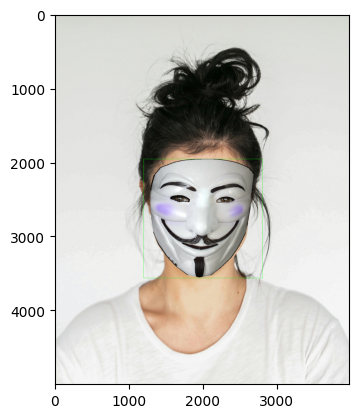

In [11]:
image_path = 'assets\\jake-nackos.jpg'
filter.filter_image(image_path, 3,)

In [8]:
filter.filter_video(2)

In [13]:
filter.filter_video(2, 'squid_game_front_man')

In [16]:
filter.filter_video2(2)

h:\Project\Filter\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [15]:
filter.filter_video2(2, 'squid_game_front_man')

h:\Project\Filter\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
